# Task 2: CNN for telling the time
---
*Author: Lukas Welzel for Group 24 (?)*

### Index:
- [Imports](#imports)
- [Main Content](#main-content) (xN)
  - [Overview](#overview)
  - [Loading Data](#loading-data)
  - [Selecting Model](#selecting-model)
  - [Experiments](#experiments)
- [Citations](#citations)
- [Footer](#footer)

In [58]:
# imports
# use environment_TTT.yaml an related IDL kernel
%load_ext autoreload
%autoreload 2
from TTTcnn import *
from default_CNNs import *
# making sure everything looks as it should
print("TF version: ", tf.__version__)
print(f"Available devices:")
[print("\t", t) for t in tf.config.list_physical_devices('GPU')]; # at least one GPU
# print(single_head_classification())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TF version:  2.6.0
Available devices:
	 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
	 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
{'learning_rate': 0.001, 'encoding': 'common_classes', 'type': ['classification'], 'actfn_normalization': ['softmax'], 'loss': ['categorical'], 'n_classes': [72], 'decay': 0.005, 'scheduler': True, 'main_stack': [<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000002819E72BE20>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000288E3F17AF0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000288E3F17A90>, <tensorflow.python.keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000288E3F179A0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000288E3F17160>, <tensorflow.python.keras.layers.pooling.MaxPooling2D

## Main Content
### Overview
In TTTcnn.py we defined a CNN by sublassing Keras' Model class. This "TellTheTimeCNN" class will be the main focus of this task. The main changes from the base Model is the setup that is now encapsulated and can be interacted with using the "settings" argument. TTTcnn.py also contains some utility functions for data loading.

### Loading Data

In [3]:
x_train, base_y_train, x_test, base_y_test = get_data()

Training data on /job:localhost/replica:0/task:0/device:GPU:0


### Selecting Model
Instances of TellTheTimeCNN have a full set of default settings, namely:

---
<blockquote>
    <p>"learning_rate":       1e-2 </p>
    <p>"epochs":              50 </p>
    <p>"batch_size":          128 </p>
    <p>"encoding":            "decimal" </p>
    <p>"type":                ["regression"],  # classification, regression (can be sequence) </p>
    <p>"actfn_normalization": ["tanh"],  # must be sequence if type is sequence </p>
    <p>"loss":                ["mse_sincos"]  # must be sequence if type is sequence </p>
</blockquote>

---

As is obvious from the last few lines the model is set up to support multiple heads.

In [4]:
# setting up a default model without a rng seed
default_model = TellTheTimeCNN()

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'reg_output_0')>]
[<function TellTheTimeCNN.mae_angle_loss at 0x000002819127A430>]
[{'accuracy': <bound method TellTheTimeCNN.metric_linear_cyclic of <TTTcnn.TellTheTimeCNN object at 0x000002819137A2B0>>}]
Model: "tell_the_time_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 

In [5]:
# the default model uses decimal encoding which we will now use
# encoding of data can be done via the encode_y function of any TellTheTimeCNN instance.
y_train, y_test = default_model.encode_y(base_y_train), default_model.encode_y(base_y_test)
try:
    print("Encoding from hh,mm -> f: ", base_y_train.shape, " -> ", y_train.shape)
except AttributeError:
    print("Encoding from hh,mm -> f: ", base_y_train.shape, " -> ", len(y_train))

Encoding from hh,mm -> f:  (14400, 2)  ->  (14400,)


In [7]:
# default_model.train(x_train, y_train)
# default_model.test(x_test, y_test)

### Experiments

Since we had large issues with training stability for both classification and regression we implement an early stopping method and learning rate schedule to improe stability and not waste training time on "lost" runs where the losses explode. We found that, optimizer making use of momentum where needed for timely convergence, however we note that simple gradient descent optimizers might have improved the stability of the training. In practice however, the architecures that were tried did not find good optima with simple optimizers and failed to converge no matter the learning rate. To further improve staiblity we attempted to implement a learning rate scheduler in combination with a function to reduce the learning rate when the validation loss plateaus. Sadly, TF2.6.0 still contains a 2 year old bug that makes this combination impossible, see e.g. https://github.com/tensorflow/tensorflow/issues/41639.

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
n_runs = 3
n_epochs = 50

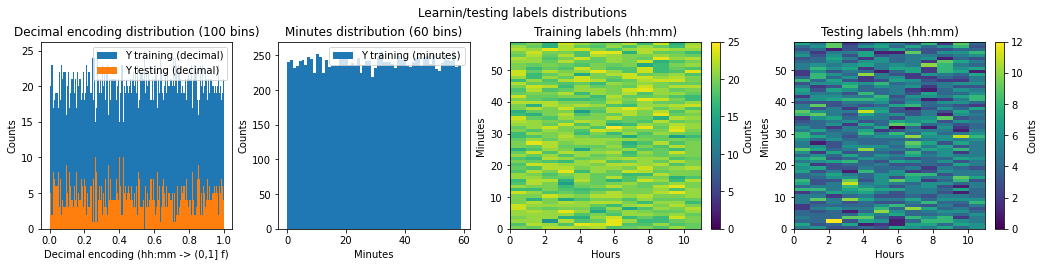

In [9]:
# Data visualization
fig, (ax, ax4, ax2, ax3) = plt.subplots(1, 4, constrained_layout=True, figsize=(24*0.6, 6*0.6))
ax.hist(y_train, bins=720, label="Y training (decimal)")
ax.hist(y_test, bins=720, label="Y testing (decimal)")
ax.set_xlabel("Decimal encoding (hh:mm -> (0,1] f)")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title("Decimal encoding distribution (100 bins)")

hist = ax2.hist2d(base_y_train[:, 0], base_y_train[:, 1], vmin=0., bins=[12, 60], label="Y training (hh:mm)")
fig.colorbar(hist[3], ax=ax2,label="Counts")
ax2.set_xlabel("Hours")
ax2.set_ylabel("Minutes")
ax2.set_title("Training labels (hh:mm)")

hist = ax3.hist2d(base_y_test[:, 0], base_y_test[:, 1], vmin=0., bins=[12, 60], label="Y testing (hh:mm)")
fig.colorbar(hist[3], ax=ax3, label="Counts")
ax3.set_xlabel("Hours")
ax3.set_ylabel("Minutes")
ax3.set_title("Testing labels (hh:mm)")

ax4.hist(base_y_train[:, 1], bins=60, label="Y training (minutes)")
ax4.set_xlabel("Minutes")
ax4.set_ylabel("Counts")
ax4.legend()
ax4.set_title("Minutes distribution (60 bins)")

fig.suptitle("Learnin/testing labels distributions")

plt.show()

In [91]:
# Classification
def prep_class_1head(settings, n_classes):
    class_head1_model = TellTheTimeCNN(settings=settings)
    y_train = class_head1_model.encode_y(base_y_train, n_classes=n_classes)
    y_test = class_head1_model.encode_y(base_y_test, n_classes=n_classes)
    return class_head1_model, y_train, y_test

def train_this(settings, n_runs=3, n_epochs=25, n_classes=72):
    data = []
    for i in range(n_runs):
        model, y_train, y_test = prep_class_1head(settings, n_classes)
        history = model.train(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=n_epochs)
        # test = default_model.test(x_test, ytest)
        data.append(history.history)
    return data # , test

In [80]:
def plot_history(hist):
    fig, (ax1) = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 6))

    ax1.set_title(f"Loss")
    for el in hist:
        ax1.plot(12. * 60. * np.array(el["loss"]), label="Training")
        ax1.plot(12. * 60. * np.array(el["val_loss"]), label="Validation")
        # ax1.scatter(len(el["loss"]) - 1, 12. * 60. * test['loss'], label="Test", c="black")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Error/Loss [minutes]")
        ax1.legend()
    
    plt.show()

In [72]:
# SINGLE HEAD CLASSIFICATION MODELS
from default_CNNs import single_head_classification
from TTTcnn import *

# settings 72 classes, single head
settings = single_head_classification(72)
c72_result = train_this(settings)

# settings 720 classes, single head, you really should not test this
# settings = {**default_classification_settings, **{"n_classes": [720]}}
# class720_head1_model, y_train, y_test = prep_class_1head(settings, 720)

classes
[<KerasTensor: shape=(None, 72) dtype=float32 (created by layer 'class_output_0')>]
['categorical_crossentropy']
ListWrapper(['accuracy', <bound method TellTheTimeCNN._class_difference of <TTTcnn.TellTheTimeCNN object at 0x000002819CB16580>>])
Model: "tell_the_time_cnn_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_68 (Rescaling)     (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 146, 146, 64)      1664      
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 73, 73, 64)        256

113/113 [==============================] - 16s 144ms/step - loss: 0.6753 - accuracy: 0.8792 - _class_difference: 0.0253 - val_loss: 1.2779 - val_accuracy: 0.5617 - val__class_difference: 0.0885
Epoch 25/50
113/113 [==============================] - 13s 118ms/step - loss: 0.6758 - accuracy: 0.8792 - _class_difference: 0.0250 - val_loss: 1.2778 - val_accuracy: 0.5617 - val__class_difference: 0.0885
Epoch 26/50
113/113 [==============================] - 16s 139ms/step - loss: 0.6765 - accuracy: 0.8769 - _class_difference: 0.0251 - val_loss: 1.2779 - val_accuracy: 0.5608 - val__class_difference: 0.0886
Epoch 27/50
113/113 [==============================] - 18s 160ms/step - loss: 0.6752 - accuracy: 0.8805 - _class_difference: 0.0250 - val_loss: 1.2781 - val_accuracy: 0.5606 - val__class_difference: 0.0888
Epoch 28/50
113/113 [==============================] - 12s 104ms/step - loss: 0.6754 - accuracy: 0.8770 - _class_difference: 0.0252 - val_loss: 1.2782 - val_accuracy: 0.5617 - val__class_d

113/113 [==============================] - 16s 138ms/step - loss: 3.6873 - accuracy: 0.0880 - _class_difference: 0.2281 - val_loss: 3.0683 - val_accuracy: 0.1633 - val__class_difference: 0.1890
Epoch 2/50
113/113 [==============================] - 14s 125ms/step - loss: 2.0711 - accuracy: 0.3368 - _class_difference: 0.1436 - val_loss: 2.6512 - val_accuracy: 0.2247 - val__class_difference: 0.1711
Epoch 3/50
113/113 [==============================] - 13s 118ms/step - loss: 1.3183 - accuracy: 0.5579 - _class_difference: 0.0954 - val_loss: 1.6558 - val_accuracy: 0.4289 - val__class_difference: 0.1246
Epoch 4/50
113/113 [==============================] - 14s 122ms/step - loss: 0.9238 - accuracy: 0.7224 - _class_difference: 0.0582 - val_loss: 1.3709 - val_accuracy: 0.5294 - val__class_difference: 0.0912
Epoch 5/50
113/113 [==============================] - 13s 114ms/step - loss: 0.6838 - accuracy: 0.8272 - _class_difference: 0.0342 - val_loss: 1.1236 - val_accuracy: 0.6261 - val__class_diffe

113/113 [==============================] - 20s 167ms/step - loss: 3.3660 - accuracy: 0.1353 - _class_difference: 0.1981 - val_loss: 2.7233 - val_accuracy: 0.2167 - val__class_difference: 0.1551
Epoch 2/50
113/113 [==============================] - 17s 153ms/step - loss: 1.5367 - accuracy: 0.4885 - _class_difference: 0.1040 - val_loss: 1.4427 - val_accuracy: 0.5003 - val__class_difference: 0.1034
Epoch 3/50
113/113 [==============================] - 13s 117ms/step - loss: 0.8253 - accuracy: 0.7528 - _class_difference: 0.0462 - val_loss: 1.2232 - val_accuracy: 0.5811 - val__class_difference: 0.0790
Epoch 4/50
113/113 [==============================] - 15s 131ms/step - loss: 0.4863 - accuracy: 0.8915 - _class_difference: 0.0188 - val_loss: 0.9481 - val_accuracy: 0.6775 - val__class_difference: 0.0575
Epoch 5/50
113/113 [==============================] - 18s 159ms/step - loss: 0.3300 - accuracy: 0.9472 - _class_difference: 0.0082 - val_loss: 0.8672 - val_accuracy: 0.7131 - val__class_diffe

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\lukas\anaconda3\envs\idl\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\lukas\AppData\Local\Temp\ipykernel_17660\1284559042.py", line 11, in <cell line: 11>
    c24_result = train_this(settings)
  File "C:\Users\lukas\AppData\Local\Temp\ipykernel_17660\894545623.py", line 12, in train_this
    history = class72_head1_model.train(x_train, y_train, validation_data=(x_test, y_test),
  File "C:\Users\lukas\Documents\Git\IDL\assingment2\TTTcnn.py", line 456, in train
    shuffle=shuffle,
  File "C:\Users\lukas\anaconda3\envs\idl\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1193, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\lukas\anaconda3\envs\idl\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\lukas\anacon

In [92]:
# settings 24 classes, single head
settings = single_head_classification(24)
c24_result = train_this(settings, n_classes=24)

classes
[<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'class_output_0')>]
['categorical_crossentropy']
ListWrapper(['accuracy', <bound method TellTheTimeCNN._class_difference of <TTTcnn.TellTheTimeCNN object at 0x000002819C9748B0>>])
Model: "tell_the_time_cnn_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_76 (Rescaling)     (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 146, 146, 64)      1664      
_________________________________________________________________
max_pooling2d_282 (MaxPoolin (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 73, 73, 64)        256

113/113 [==============================] - 13s 118ms/step - loss: 0.2767 - accuracy: 0.9682 - _class_difference: 0.0031 - val_loss: 0.6659 - val_accuracy: 0.7869 - val__class_difference: 0.0245
Epoch 25/25
113/113 [==============================] - 14s 120ms/step - loss: 0.2765 - accuracy: 0.9669 - _class_difference: 0.0034 - val_loss: 0.6656 - val_accuracy: 0.7869 - val__class_difference: 0.0245
classes
[<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'class_output_0')>]
['categorical_crossentropy']
ListWrapper(['accuracy', <bound method TellTheTimeCNN._class_difference of <TTTcnn.TellTheTimeCNN object at 0x000002819E785CD0>>])
Model: "tell_the_time_cnn_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_76 (Rescaling)     (None, 150, 150, 1)      

113/113 [==============================] - 13s 117ms/step - loss: 0.1461 - accuracy: 0.9754 - _class_difference: 0.0025 - val_loss: 0.4153 - val_accuracy: 0.8683 - val__class_difference: 0.0128
Epoch 23/25
113/113 [==============================] - 14s 122ms/step - loss: 0.1457 - accuracy: 0.9762 - _class_difference: 0.0024 - val_loss: 0.4154 - val_accuracy: 0.8686 - val__class_difference: 0.0128
Epoch 24/25
113/113 [==============================] - 13s 114ms/step - loss: 0.1459 - accuracy: 0.9749 - _class_difference: 0.0027 - val_loss: 0.4154 - val_accuracy: 0.8686 - val__class_difference: 0.0130
Epoch 25/25
113/113 [==============================] - 12s 109ms/step - loss: 0.1454 - accuracy: 0.9756 - _class_difference: 0.0025 - val_loss: 0.4153 - val_accuracy: 0.8686 - val__class_difference: 0.0128
classes
[<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'class_output_0')>]
['categorical_crossentropy']
ListWrapper(['accuracy', <bound method TellTheTimeCNN._class_differ

In [93]:
# settings 12 classes, single head
settings = single_head_classification(12)
c12_result = train_this(settings, n_classes=12)

classes
[<KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'class_output_0')>]
['categorical_crossentropy']
ListWrapper(['accuracy', <bound method TellTheTimeCNN._class_difference of <TTTcnn.TellTheTimeCNN object at 0x00000288D71B92B0>>])
Model: "tell_the_time_cnn_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_80 (Rescaling)     (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 146, 146, 64)      1664      
_________________________________________________________________
max_pooling2d_296 (MaxPoolin (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_141 (Bat (None, 73, 73, 64)        256

113/113 [==============================] - 17s 145ms/step - loss: 1.9228 - accuracy: 0.2747 - _class_difference: 0.1509 - val_loss: 1.4792 - val_accuracy: 0.3789 - val__class_difference: 0.1041
Epoch 2/25
113/113 [==============================] - 15s 137ms/step - loss: 0.9937 - accuracy: 0.5813 - _class_difference: 0.0574 - val_loss: 1.5650 - val_accuracy: 0.3889 - val__class_difference: 0.1914
Epoch 3/25
113/113 [==============================] - 13s 114ms/step - loss: 0.8849 - accuracy: 0.6306 - _class_difference: 0.0488 - val_loss: 1.4683 - val_accuracy: 0.4242 - val__class_difference: 0.0928
Epoch 4/25
113/113 [==============================] - 19s 170ms/step - loss: 1.1007 - accuracy: 0.5542 - _class_difference: 0.0615 - val_loss: 2.4877 - val_accuracy: 0.2419 - val__class_difference: 0.2524
Epoch 5/25
113/113 [==============================] - 13s 118ms/step - loss: 1.2337 - accuracy: 0.5450 - _class_difference: 0.0643 - val_loss: 2.0816 - val_accuracy: 0.3133 - val__class_diffe

113/113 [==============================] - 14s 126ms/step - loss: 2.5978 - accuracy: 0.4058 - _class_difference: 0.1039 - val_loss: 3.4713 - val_accuracy: 0.3458 - val__class_difference: 0.1206
Epoch 12/25
113/113 [==============================] - 18s 156ms/step - loss: 2.5622 - accuracy: 0.4076 - _class_difference: 0.1028 - val_loss: 3.4442 - val_accuracy: 0.3433 - val__class_difference: 0.1156
Epoch 13/25
113/113 [==============================] - 14s 125ms/step - loss: 2.5881 - accuracy: 0.4070 - _class_difference: 0.1044 - val_loss: 3.3523 - val_accuracy: 0.3436 - val__class_difference: 0.1154


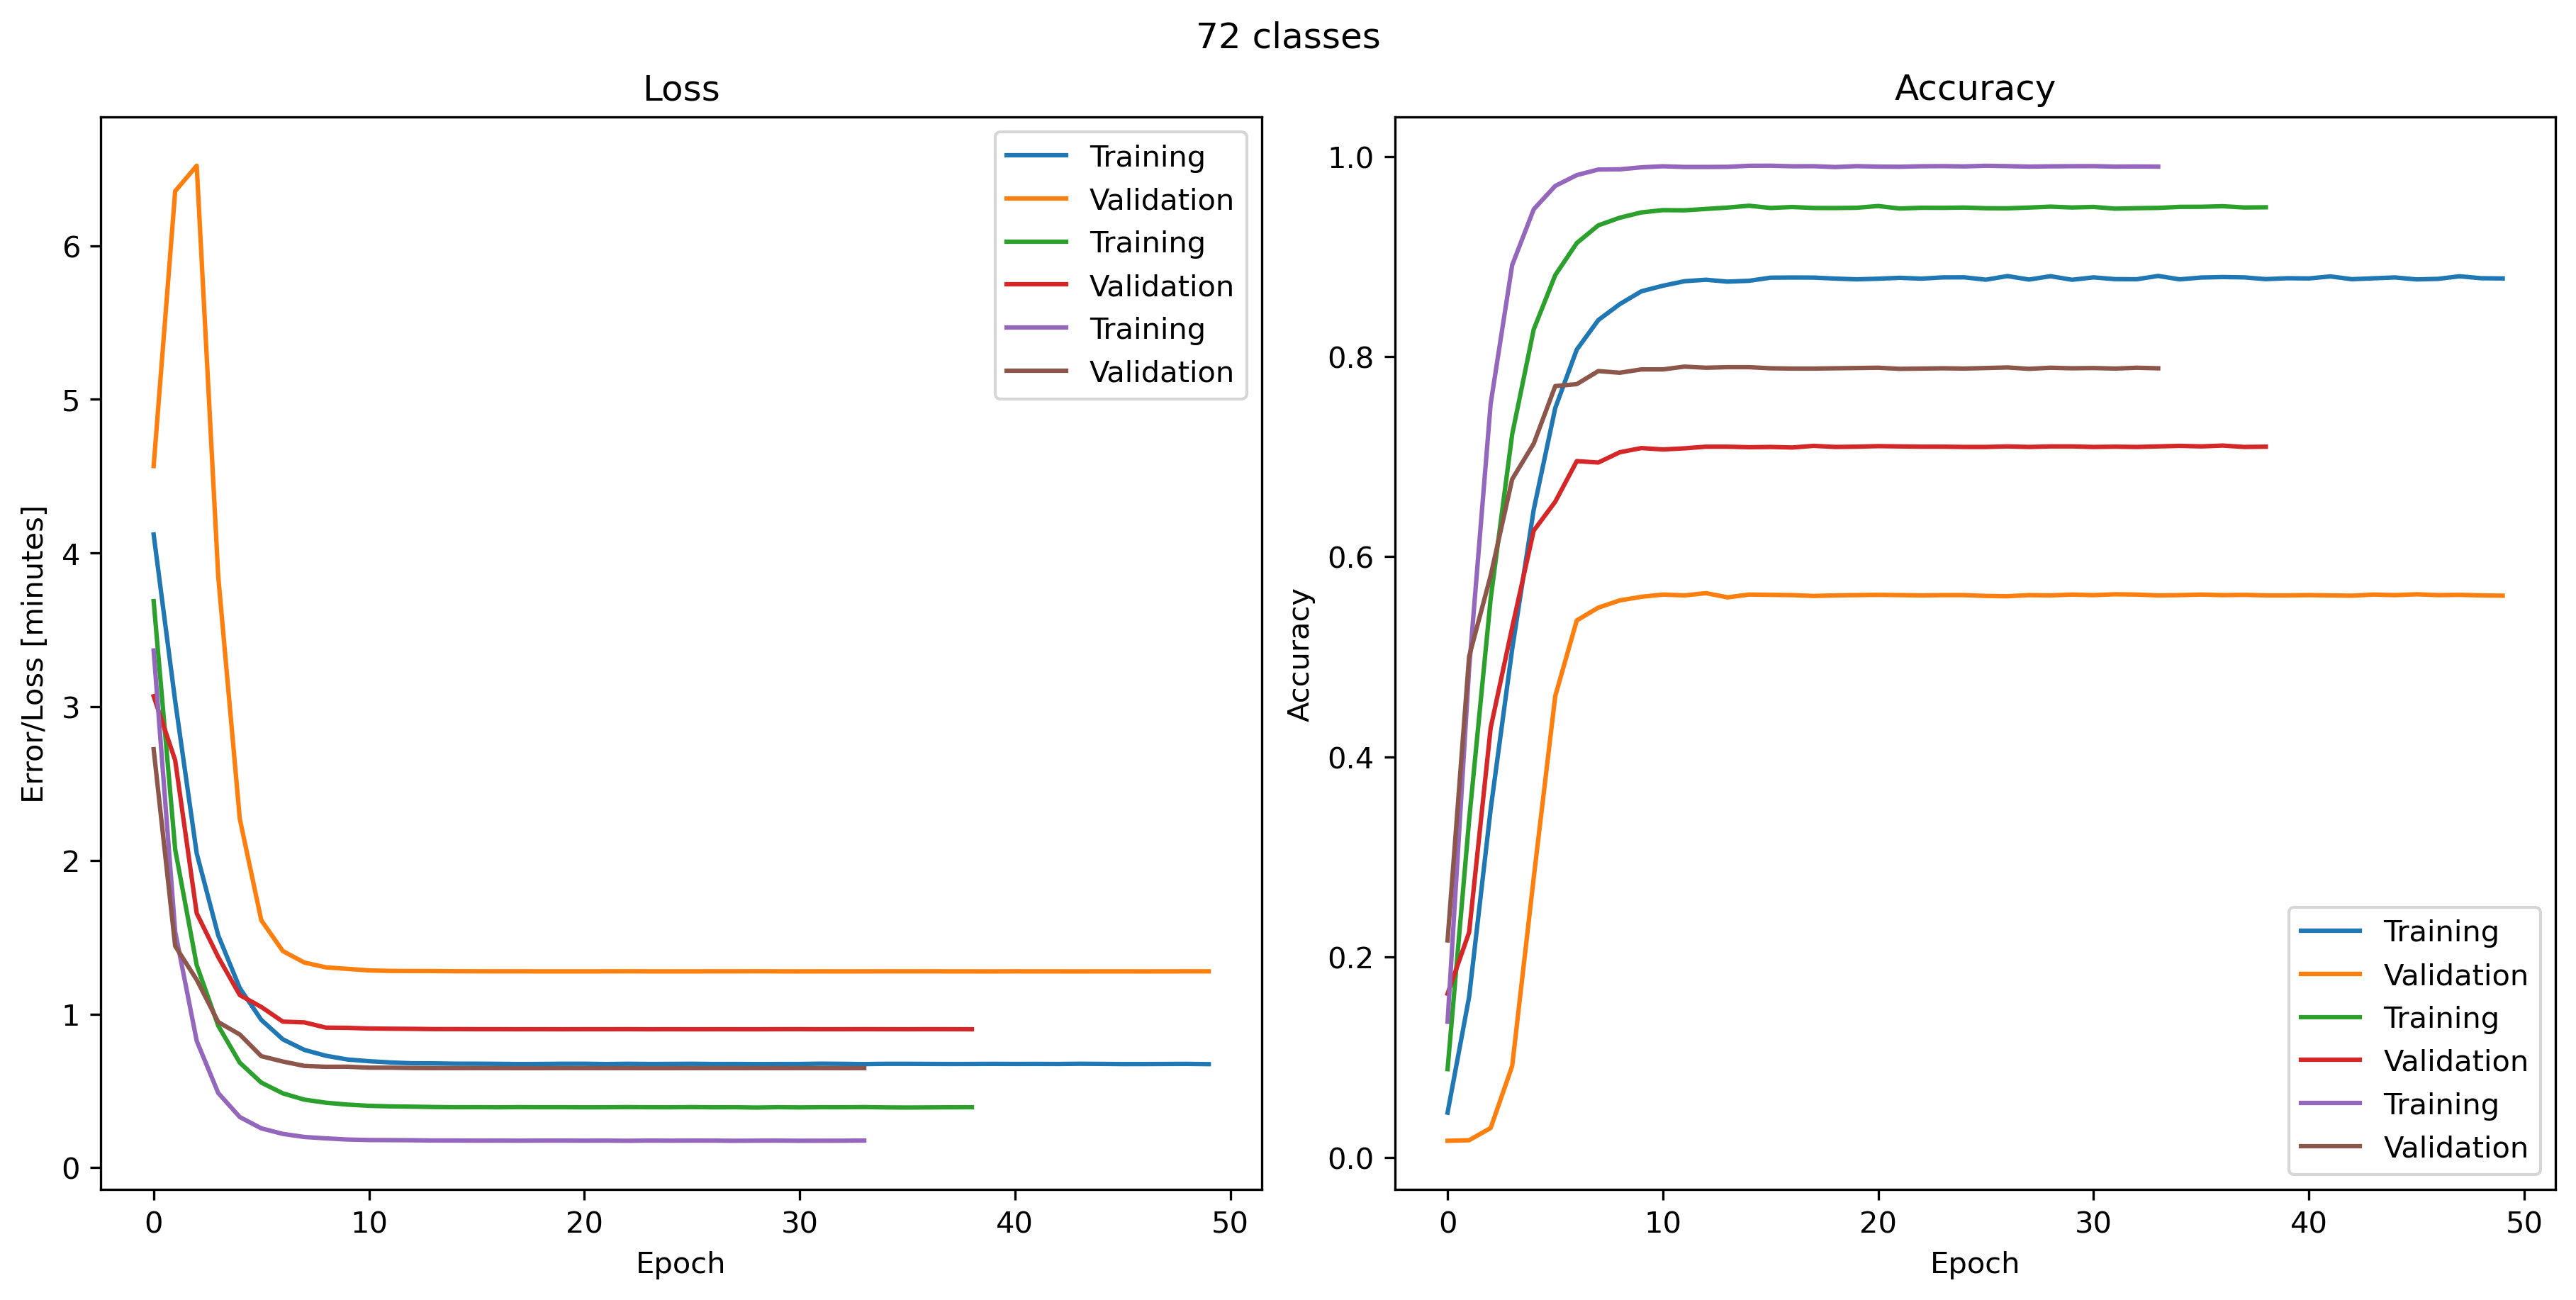

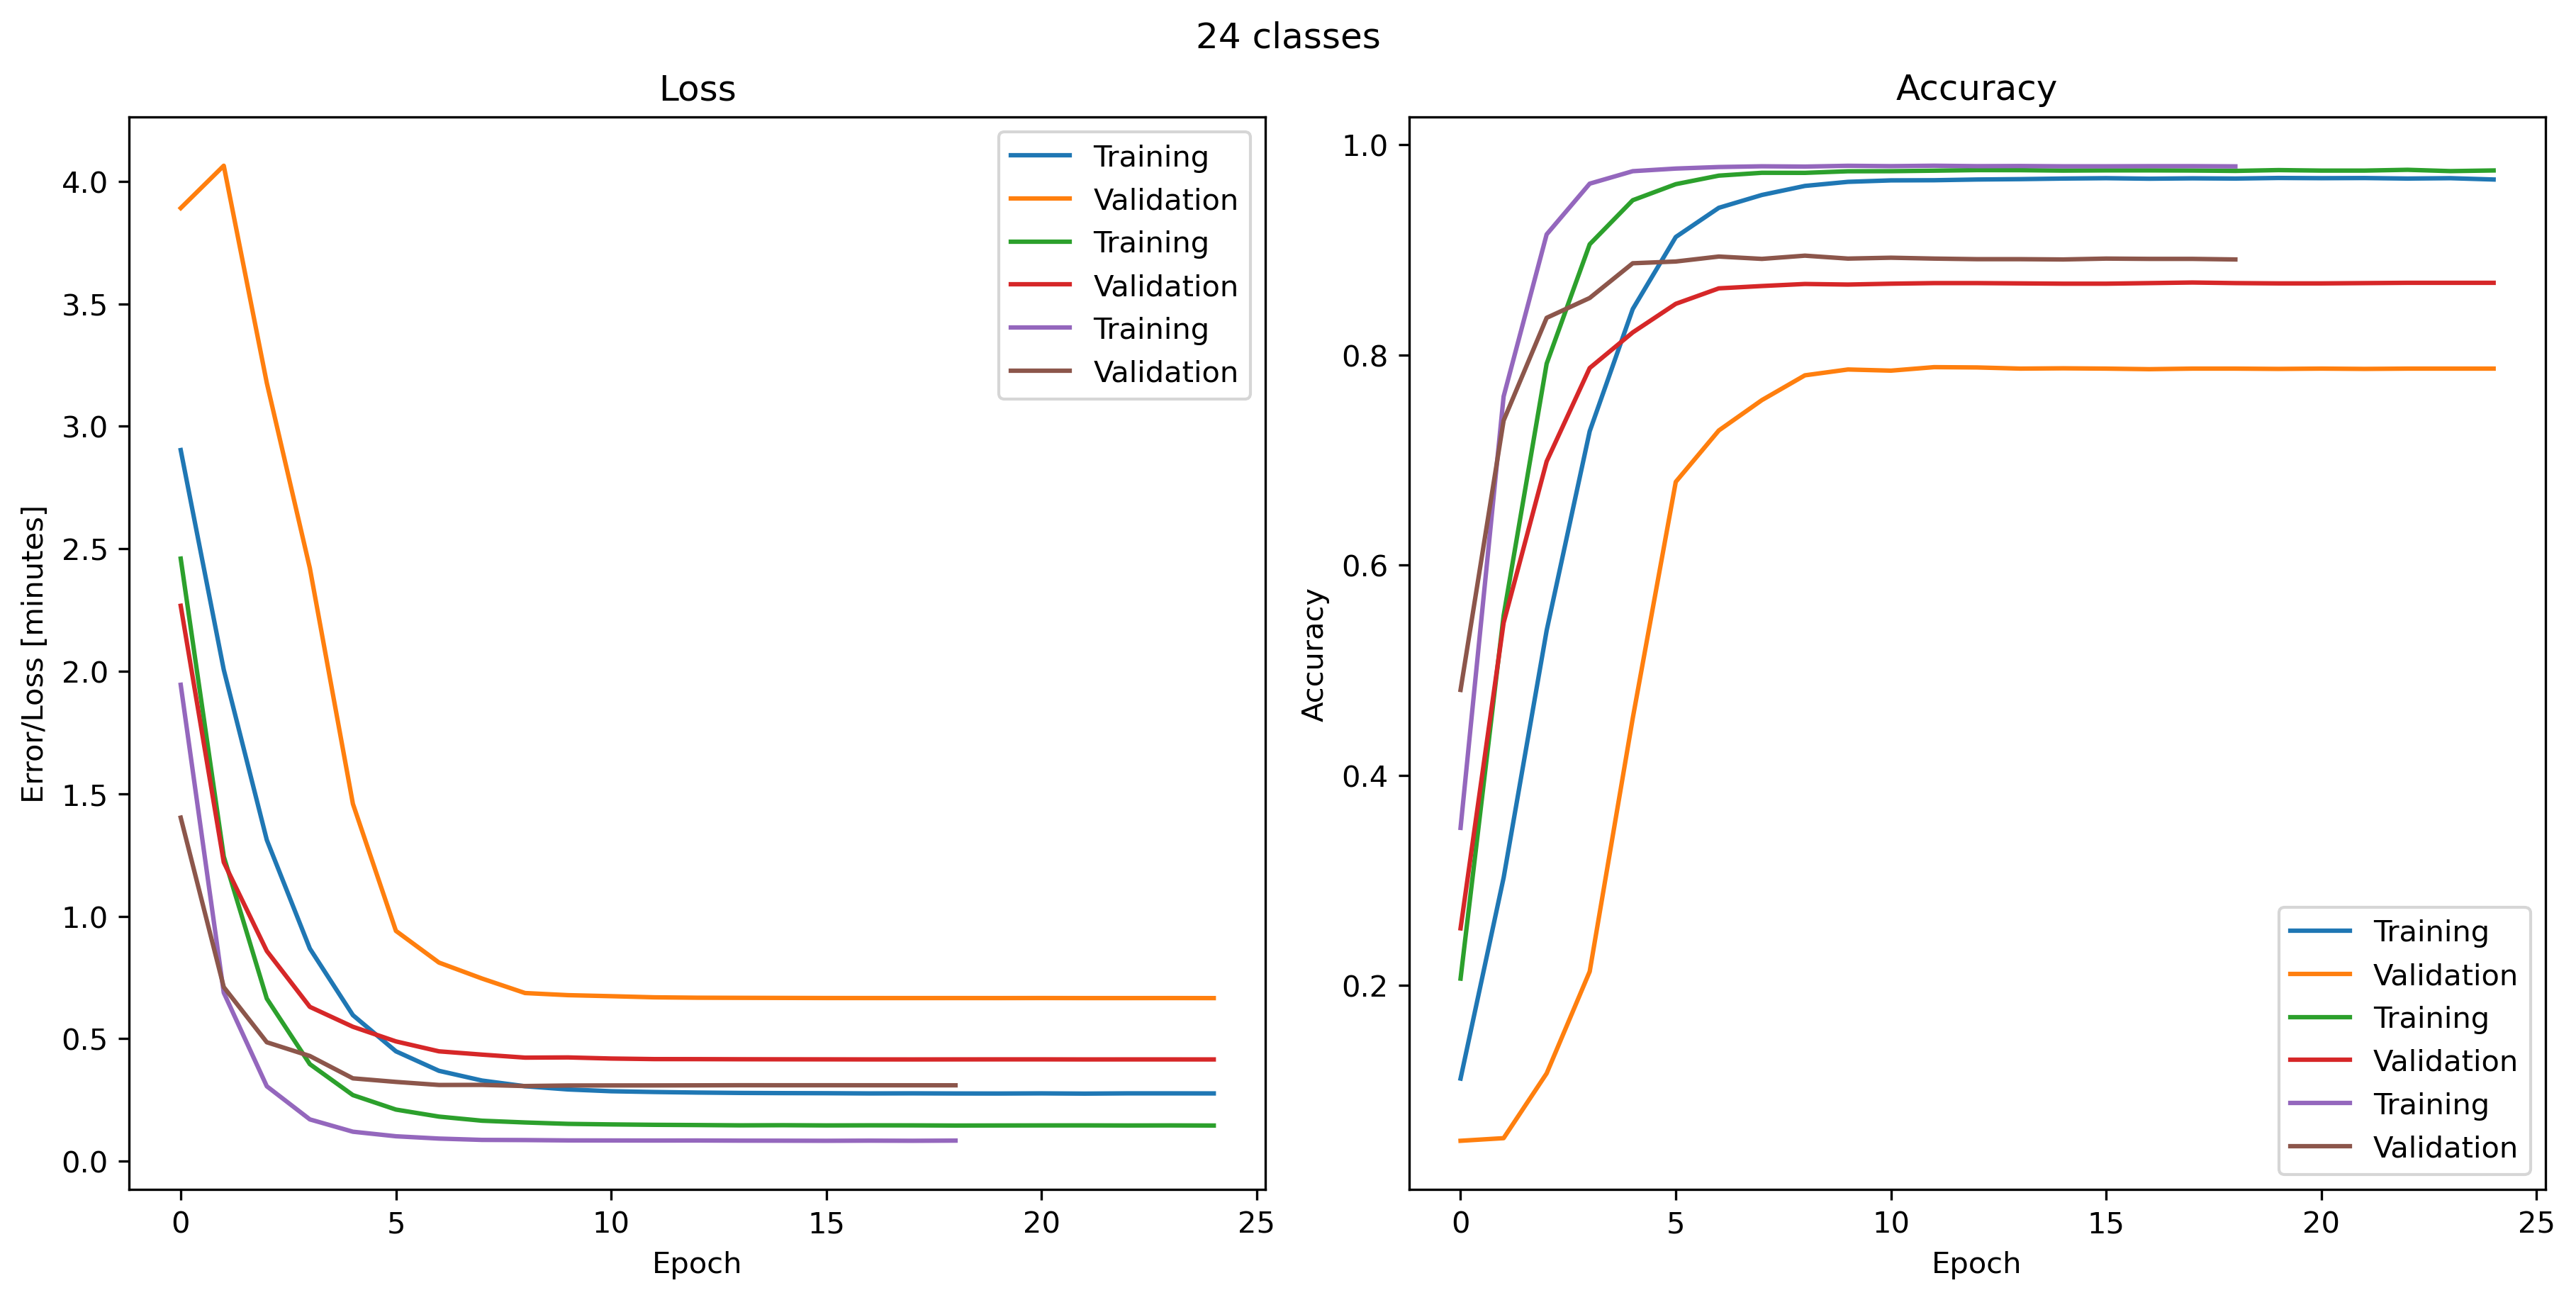

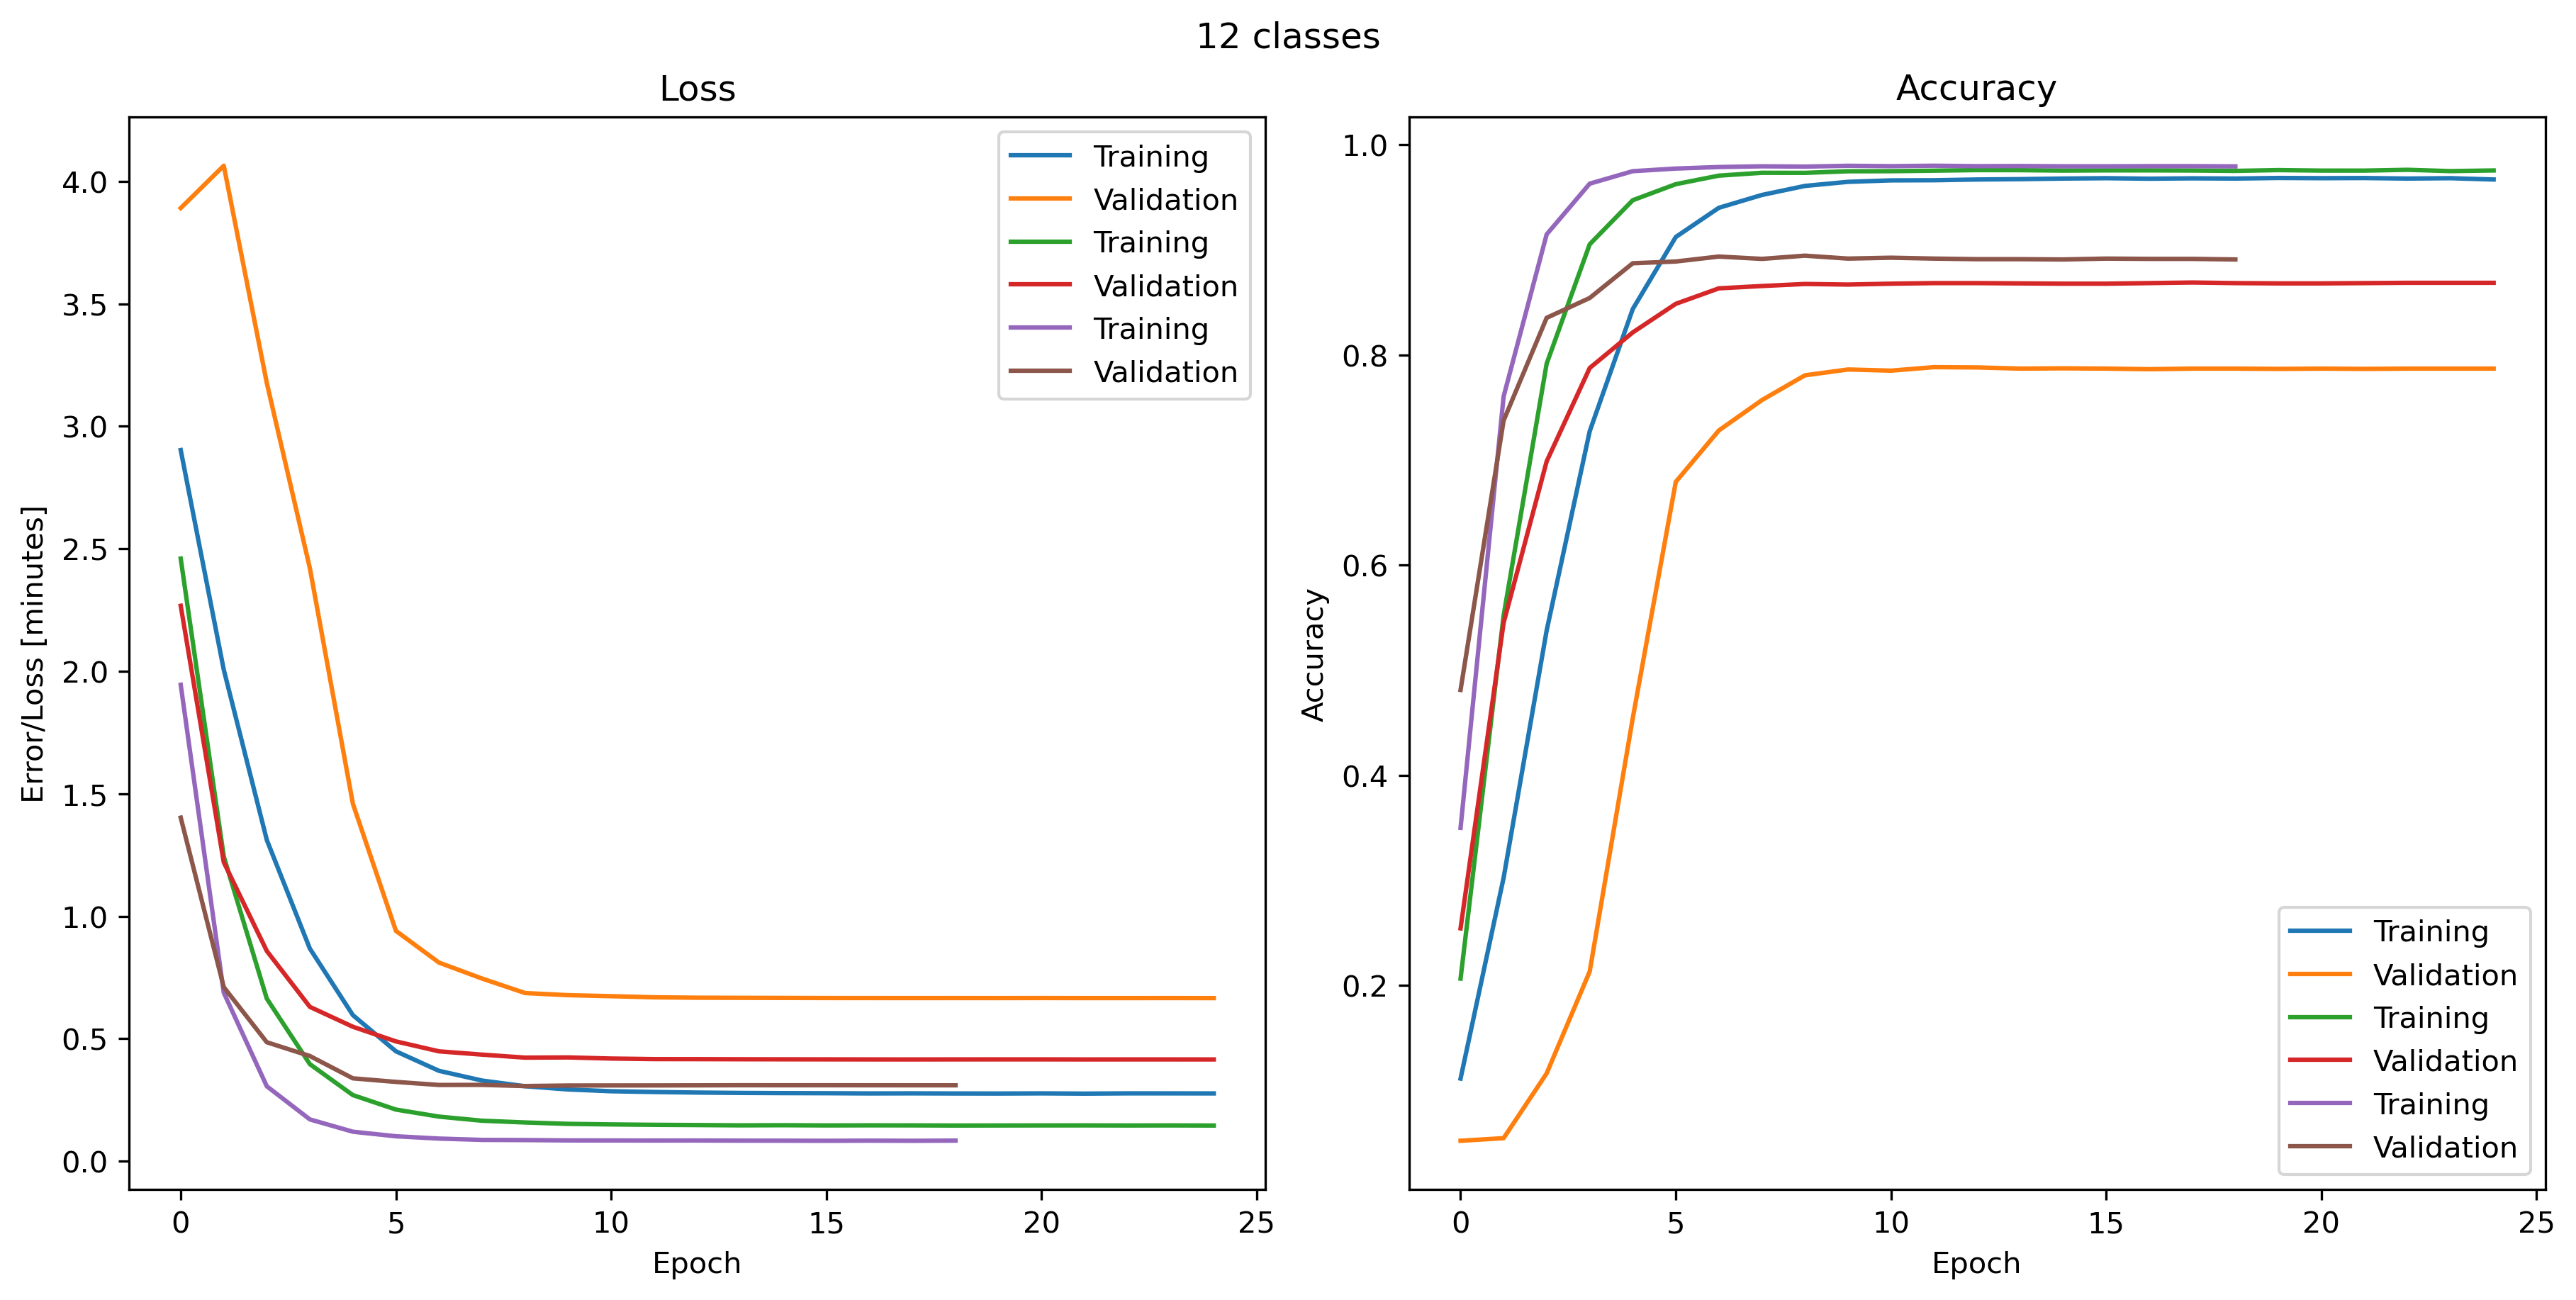

In [94]:
def plot_history(hist, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

    ax1.set_title(f"Loss")
    ax2.set_title(f"Accuracy")
    for el in hist:
        ax1.plot(np.array(el["loss"]), label="Training")
        ax1.plot(np.array(el["val_loss"]), label="Validation")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Error/Loss")
        ax1.legend()
        
    
        ax2.plot(el["accuracy"], label="Training")
        ax2.plot(el["val_accuracy"], label="Validation")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
    
    fig.suptitle(title)
    
    plt.show()

    
plot_history(c72_result, "72 classes")
plot_history(c24_result, "24 classes")
plot_history(c12_result, "12 classes")
# print(c72_result[0])
#print(c24_result) 
#print(c12_result)

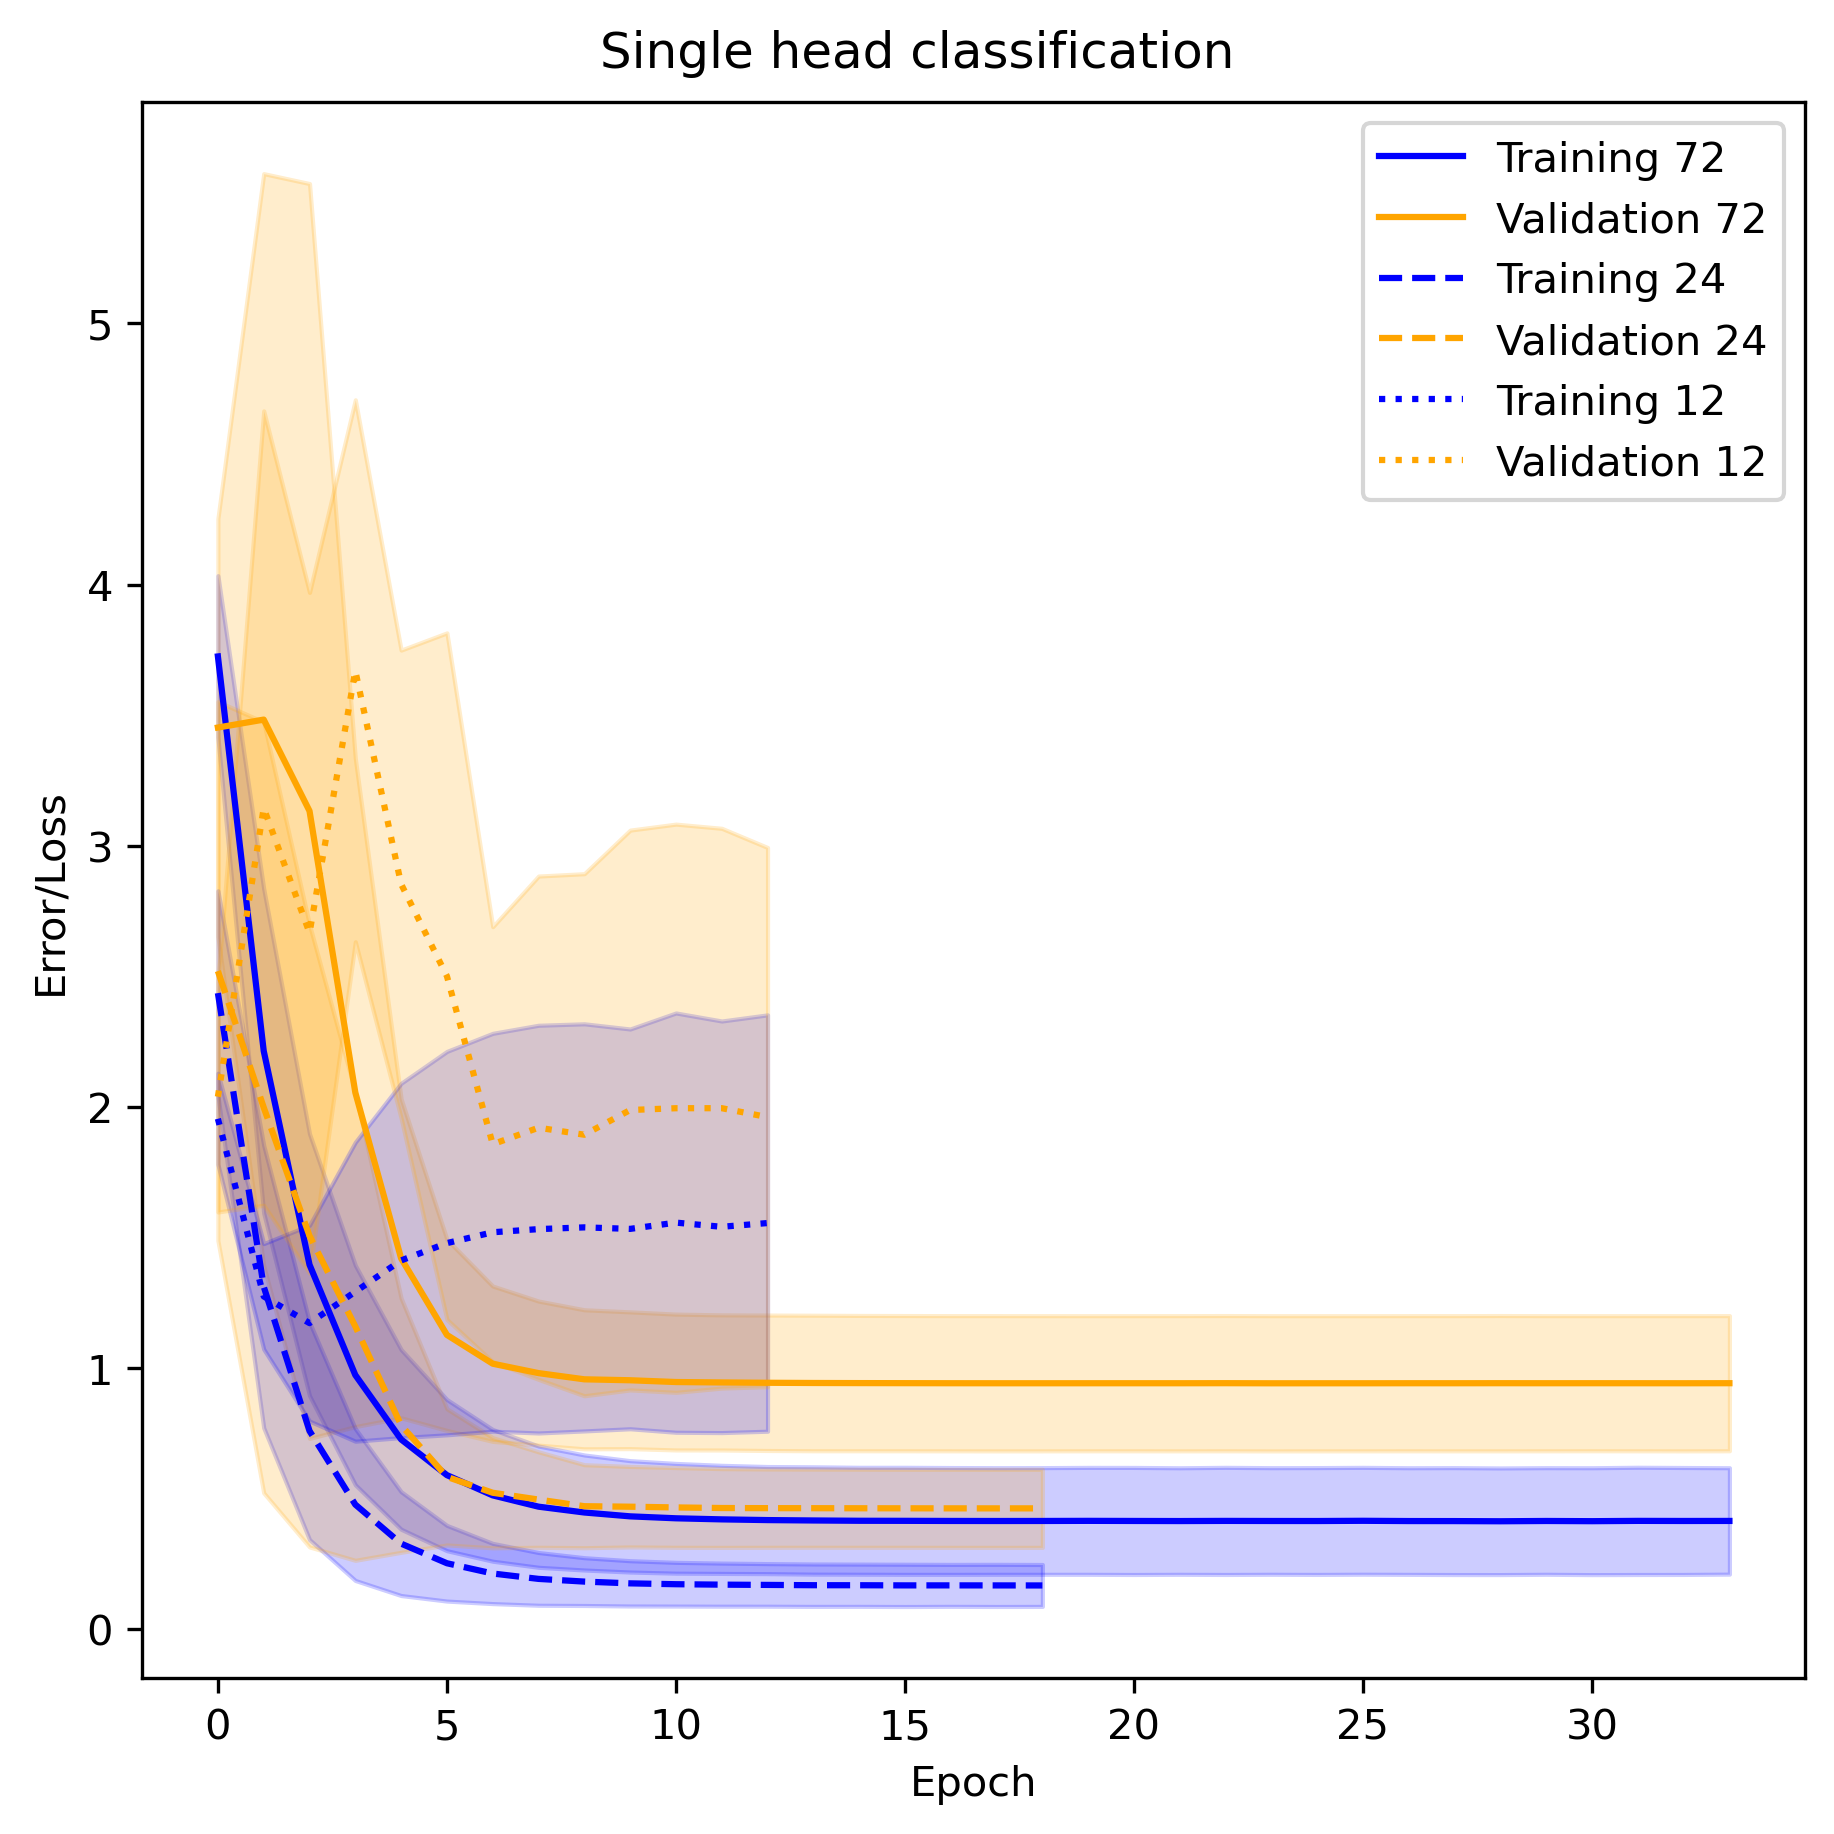

In [104]:
def plot_comb_history(hists, title=""):
    fig, (ax1) = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6))
    
    colors = ["blue", "orange"]
    lss = ["solid", "dashed", "dotted"]
    labels = ["72", "24", "12"]

    ax1.set_title(f"Loss")
    ax2.set_title(f"Accuracy")
    for hist, ls, label in zip(hists, lss, labels):
        l = np.min([len(el["loss"]) for el in hist])
        losses = np.array([el["loss"][:l] for el in hist])
        accuracy = np.array([el["accuracy"][:l] for el in hist])
        
        val_losses = np.array([el["val_loss"][:l] for el in hist])
        val_accuracy = np.array([el["val_accuracy"][:l] for el in hist])
        
        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        
        mean_val_loss = np.mean(val_losses, axis=0)
        std_val_loss = np.std(val_losses, axis=0)
        
        mean_accuracy = np.mean(losses, axis=0)
        std_accuracy = np.std(losses, axis=0)
        
        mean_val_accuracy = np.mean(val_losses, axis=0)
        std_val_accuracy = np.std(val_losses, axis=0)
        
        x = np.arange(len(mean_loss))
        ax1.plot(mean_loss, label=f"Training {label}", ls=ls, c="blue")
        ax1.fill_between(x,
                        mean_loss + std_loss,
                        mean_loss - std_loss, color="blue", alpha=0.2)
        ax1.plot(mean_val_loss, label=f"Validation {label}", ls=ls, c="orange")
        ax1.fill_between(x,
                mean_val_loss + std_val_loss,
                mean_val_loss - std_val_loss, color="orange", alpha=0.2)

        
    
        ax2.plot(mean_accuracy, label=f"Training {label}", ls=ls, c="blue")
        ax2.fill_between(x,
                mean_accuracy + std_accuracy,
                mean_accuracy - std_accuracy, color="blue", alpha=0.2)
        ax2.plot(mean_val_accuracy, label=f"Validation {label}", ls=ls, c="orange")
        ax2.fill_between(x,
                         mean_val_accuracy + std_val_accuracy,
                         mean_val_accuracy - std_val_accuracy, color="orange", alpha=0.2)
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Error/Loss")
    ax1.legend()

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
    fig.suptitle(title)
    
    plt.show()

    
plot_comb_history([c72_result, c24_result, c12_result], "Single head classification")

### Regression
We had significant issues with regression. Almost no architecture worked well, and those that worked still had large errors.

In [98]:
# Regression
def prep_reg_1head(settings):
    model = TellTheTimeCNN(settings=settings)
    y_train = model.encode_y(base_y_train)
    y_test = model.encode_y(base_y_test)
    return model, y_train, y_test

def train_this(settings, n_runs=3, n_epochs=25):
    data = []
    for i in range(n_runs):
        model, y_train, y_test = prep_reg_1head(settings)
        history = model.train(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=n_epochs)
        # test = default_model.test(x_test, ytest)
        data.append(history.history)
    return data # , test

from default_CNNs import single_large_head_regression, single_head_regression
from TTTcnn import *

In [99]:
settings = single_large_head_regression()
r_dec_large_result = train_this(settings)

linear
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'reg_output_0')>]
['mse']
<bound method TellTheTimeCNN.metric_linear_cyclic of <TTTcnn.TellTheTimeCNN object at 0x00000281A1147B50>>
Model: "tell_the_time_cnn_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_86 (Rescaling)     (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_316 (MaxPoolin (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_317 (Conv2D)          (None, 71, 71, 32)        4640      
_________________________________________

Epoch 1/25
113/113 [==============================] - 4s 32ms/step - loss: 11.8369 - metric_linear_cyclic: 1693.6575 - val_loss: 32.8636 - val_metric_linear_cyclic: 3366.2263
Epoch 2/25
113/113 [==============================] - 4s 35ms/step - loss: 6.2168 - metric_linear_cyclic: 1135.7482 - val_loss: 18.4546 - val_metric_linear_cyclic: 2373.1511
Epoch 3/25
113/113 [==============================] - 4s 32ms/step - loss: 3.7864 - metric_linear_cyclic: 842.0923 - val_loss: 12.7001 - val_metric_linear_cyclic: 1846.0527
Epoch 4/25
113/113 [==============================] - 4s 35ms/step - loss: 2.3533 - metric_linear_cyclic: 650.1365 - val_loss: 13.5980 - val_metric_linear_cyclic: 1885.6342
Epoch 5/25
113/113 [==============================] - 4s 32ms/step - loss: 1.3606 - metric_linear_cyclic: 482.6334 - val_loss: 6.8172 - val_metric_linear_cyclic: 1267.0770
Epoch 6/25
113/113 [==============================] - 4s 32ms/step - loss: 0.9193 - metric_linear_cyclic: 395.5497 - val_loss: 5.5027

113/113 [==============================] - 4s 36ms/step - loss: 0.4486 - metric_linear_cyclic: 290.0016 - val_loss: 4.4192 - val_metric_linear_cyclic: 817.6669
Epoch 11/25
113/113 [==============================] - 4s 33ms/step - loss: 0.4634 - metric_linear_cyclic: 291.8224 - val_loss: 5.7007 - val_metric_linear_cyclic: 984.8021
Epoch 12/25
113/113 [==============================] - 4s 33ms/step - loss: 0.4393 - metric_linear_cyclic: 285.5398 - val_loss: 4.6614 - val_metric_linear_cyclic: 902.9537
Epoch 13/25
113/113 [==============================] - 4s 34ms/step - loss: 0.4064 - metric_linear_cyclic: 276.9864 - val_loss: 4.8576 - val_metric_linear_cyclic: 955.9880
Epoch 14/25
113/113 [==============================] - 4s 32ms/step - loss: 0.3700 - metric_linear_cyclic: 269.3450 - val_loss: 4.7386 - val_metric_linear_cyclic: 807.4928
Epoch 15/25
113/113 [==============================] - 4s 33ms/step - loss: 0.3635 - metric_linear_cyclic: 266.1920 - val_loss: 4.1822 - val_metric_line

In [100]:
settings = single_head_regression()
r_dec_result = train_this(settings)

linear
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'reg_output_0')>]
[<function TellTheTimeCNN.linear_cyclic_loss at 0x000002891B2D7670>]
<bound method TellTheTimeCNN.metric_linear_cyclic of <TTTcnn.TellTheTimeCNN object at 0x000002819E46D9D0>>
Model: "tell_the_time_cnn_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling_90 (Rescaling)     (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_328 (MaxPoolin (None, 145, 145, 32)      0         
_________________________________________________________________
batch_normalization_150 (Bat (None, 145, 145, 

Epoch 1/25
113/113 [==============================] - 29s 253ms/step - loss: 1.4845 - metric_linear_cyclic: 355.1003 - val_loss: 363.6107 - val_metric_linear_cyclic: 12384.0146
Epoch 2/25
113/113 [==============================] - 27s 236ms/step - loss: 0.0838 - metric_linear_cyclic: 179.3623 - val_loss: 2.3220 - val_metric_linear_cyclic: 840.9987
Epoch 3/25
113/113 [==============================] - 40s 355ms/step - loss: 0.0767 - metric_linear_cyclic: 169.6968 - val_loss: 0.2261 - val_metric_linear_cyclic: 268.2468
Epoch 4/25
113/113 [==============================] - 26s 231ms/step - loss: 0.0715 - metric_linear_cyclic: 161.8761 - val_loss: 0.0964 - val_metric_linear_cyclic: 187.9895
Epoch 5/25
113/113 [==============================] - 26s 231ms/step - loss: 0.0677 - metric_linear_cyclic: 157.0559 - val_loss: 0.0621 - val_metric_linear_cyclic: 148.4324
Epoch 6/25
113/113 [==============================] - 29s 260ms/step - loss: 0.0639 - metric_linear_cyclic: 151.2164 - val_loss: 0.

Epoch 3/25
113/113 [==============================] - 46s 404ms/step - loss: 0.0836 - metric_linear_cyclic: 176.9250 - val_loss: 0.0904 - val_metric_linear_cyclic: 183.2422
Epoch 4/25
113/113 [==============================] - 35s 311ms/step - loss: 0.0799 - metric_linear_cyclic: 172.9884 - val_loss: 0.0807 - val_metric_linear_cyclic: 176.0130
Epoch 5/25
113/113 [==============================] - 35s 310ms/step - loss: 0.0742 - metric_linear_cyclic: 165.8725 - val_loss: 0.0922 - val_metric_linear_cyclic: 187.7391
Epoch 6/25
113/113 [==============================] - 27s 240ms/step - loss: 0.0779 - metric_linear_cyclic: 169.2647 - val_loss: 0.0826 - val_metric_linear_cyclic: 176.1562
Epoch 7/25
113/113 [==============================] - 39s 350ms/step - loss: 0.0724 - metric_linear_cyclic: 162.9143 - val_loss: 0.0719 - val_metric_linear_cyclic: 162.7168
Epoch 8/25
113/113 [==============================] - 37s 329ms/step - loss: 0.0791 - metric_linear_cyclic: 171.7606 - val_loss: 0.0942

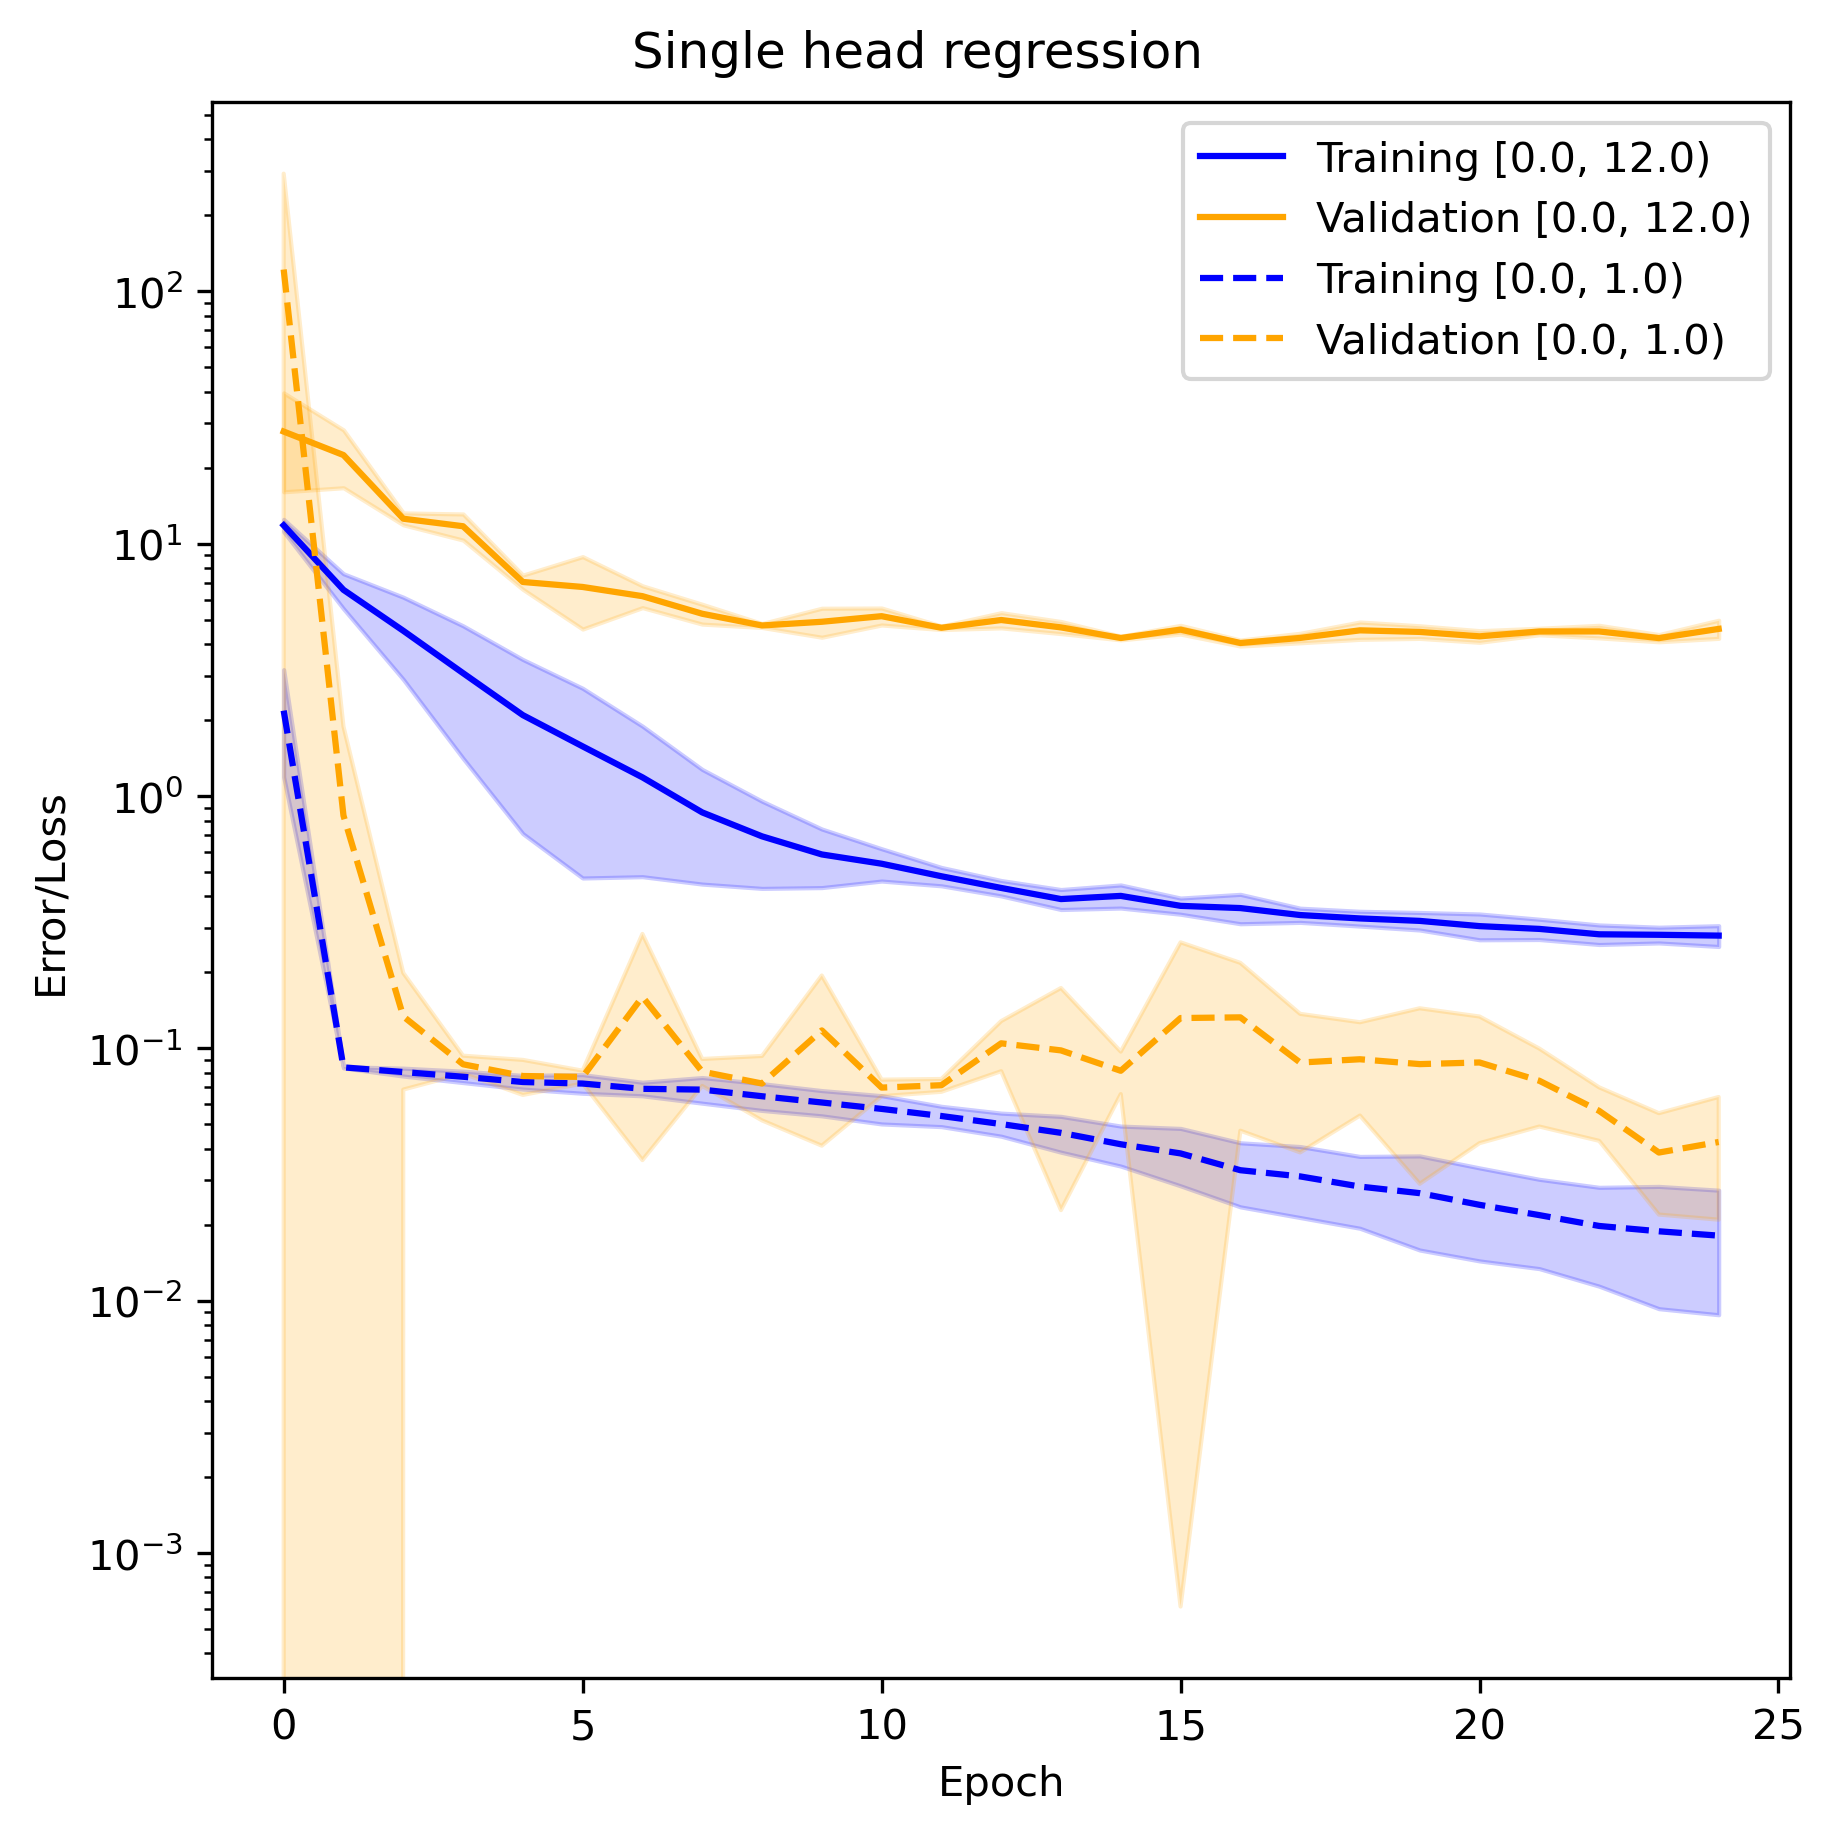

In [113]:
def plot_comb_reg_history(hists, title=""):
    fig, (ax1) = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6))
    
    colors = ["blue", "orange"]
    lss = ["solid", "dashed", "dotted"]
    labels = ["[0.0, 12.0)", "[0.0, 1.0)"]

    # ax1.set_title(f"Loss")
    # ax2.set_title(f"Accuracy")
    for hist, ls, label in zip(hists, lss, labels):
        l = np.min([len(el["loss"]) for el in hist])
        losses = np.array([el["loss"][:l] for el in hist])
        # accuracy = np.array([el["accuracy"][:l] for el in hist])
        
        val_losses = np.array([el["val_loss"][:l] for el in hist])
        #val_accuracy = np.array([el["val_accuracy"][:l] for el in hist])
        
        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        
        mean_val_loss = np.mean(val_losses, axis=0)
        std_val_loss = np.std(val_losses, axis=0)
        
        #mean_accuracy = np.mean(losses, axis=0)
        #std_accuracy = np.std(losses, axis=0)
        
        #mean_val_accuracy = np.mean(val_losses, axis=0)
        #std_val_accuracy = np.std(val_losses, axis=0)
        
        x = np.arange(len(mean_loss))
        ax1.plot(mean_loss, label=f"Training {label}", ls=ls, c="blue")
        ax1.fill_between(x,
                        mean_loss + std_loss,
                        mean_loss - std_loss, color="blue", alpha=0.2)
        ax1.plot(mean_val_loss, label=f"Validation {label}", ls=ls, c="orange")
        ax1.fill_between(x,
                mean_val_loss + std_val_loss,
                mean_val_loss - std_val_loss, color="orange", alpha=0.2)

        
    
#         ax2.plot(mean_accuracy, label=f"Training {label}", ls=ls, c="blue")
#         ax2.fill_between(x,
#                 mean_accuracy + std_accuracy,
#                 mean_accuracy - std_accuracy, color="blue", alpha=0.2)
#         ax2.plot(mean_val_accuracy, label=f"Validation {label}", ls=ls, c="orange")
#         ax2.fill_between(x,
#                          mean_val_accuracy + std_val_accuracy,
#                          mean_val_accuracy - std_val_accuracy, color="orange", alpha=0.2)
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Error/Loss")
    ax1.legend()
    ax1.set_yscale("log")

#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Accuracy")
#     ax2.legend()
    
    fig.suptitle(title)
    
    plt.show()

    
plot_comb_reg_history([r_dec_large_result, r_dec_result], "Single head regression")

In [117]:
# Multihead

# Regression
def prep_reg_1head(settings):
    model = TellTheTimeCNN(settings=settings)
    y_train = model.encode_y(base_y_train)
    y_test = model.encode_y(base_y_test)
    return model, y_train, y_test

def train_this(settings, n_runs=3, n_epochs=25):
    data = []
    for i in range(n_runs):
        model, y_train, y_test = prep_reg_1head(settings)
        history = model.train(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=n_epochs)
        # test = default_model.test(x_test, ytest)
        data.append(history.history)
    return data # , test

from default_CNNs import big_double_head_regression
from TTTcnn import *

In [118]:
settings = big_double_head_regression()
r_cossin_2head_result = train_this(settings)

2head
Model: "tell_the_time_cnn_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
rescaling_98 (Rescaling)        (None, 150, 150, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_358 (Conv2D)             (None, 146, 146, 64) 1664        rescaling_98[0][0]               
__________________________________________________________________________________________________
max_pooling2d_358 (MaxPooling2D (None, 73, 73, 64)   0           conv2d_358[0][0]                 
_________________________________________________________________________

113/113 [==============================] - 12s 109ms/step - loss: 0.0393 - rescaling_100_loss: 0.0187 - rescaling_101_loss: 0.0206 - rescaling_100_accuracy: 0.5152 - rescaling_101_accuracy: 0.5146 - val_loss: 0.1801 - val_rescaling_100_loss: 0.0914 - val_rescaling_101_loss: 0.0888 - val_rescaling_100_accuracy: 0.4978 - val_rescaling_101_accuracy: 0.4989
Epoch 7/25
113/113 [==============================] - 21s 187ms/step - loss: 0.0358 - rescaling_100_loss: 0.0175 - rescaling_101_loss: 0.0183 - rescaling_100_accuracy: 0.5169 - rescaling_101_accuracy: 0.5163 - val_loss: 0.5595 - val_rescaling_100_loss: 0.2960 - val_rescaling_101_loss: 0.2635 - val_rescaling_100_accuracy: 0.4289 - val_rescaling_101_accuracy: 0.4336
Epoch 8/25
113/113 [==============================] - 19s 165ms/step - loss: 0.0363 - rescaling_100_loss: 0.0175 - rescaling_101_loss: 0.0188 - rescaling_100_accuracy: 0.5152 - rescaling_101_accuracy: 0.5150 - val_loss: 0.3096 - val_rescaling_100_loss: 0.1696 - val_rescaling_1

113/113 [==============================] - 23s 194ms/step - loss: 1.2257 - rescaling_103_loss: 0.6087 - rescaling_104_loss: 0.6171 - rescaling_103_accuracy: 0.4253 - rescaling_104_accuracy: 0.4293 - val_loss: 0.6739 - val_rescaling_103_loss: 0.3562 - val_rescaling_104_loss: 0.3177 - val_rescaling_103_accuracy: 0.3864 - val_rescaling_104_accuracy: 0.4358
Epoch 2/25
113/113 [==============================] - 22s 192ms/step - loss: 0.0775 - rescaling_103_loss: 0.0375 - rescaling_104_loss: 0.0400 - rescaling_103_accuracy: 0.5083 - rescaling_104_accuracy: 0.5064 - val_loss: 0.3668 - val_rescaling_103_loss: 0.1742 - val_rescaling_104_loss: 0.1926 - val_rescaling_103_accuracy: 0.4711 - val_rescaling_104_accuracy: 0.4442
Epoch 3/25
113/113 [==============================] - 24s 212ms/step - loss: 0.0500 - rescaling_103_loss: 0.0253 - rescaling_104_loss: 0.0247 - rescaling_103_accuracy: 0.5128 - rescaling_104_accuracy: 0.5126 - val_loss: 0.2946 - val_rescaling_103_loss: 0.1443 - val_rescaling_1

113/113 [==============================] - 15s 137ms/step - loss: 0.0166 - rescaling_103_loss: 0.0083 - rescaling_104_loss: 0.0083 - rescaling_103_accuracy: 0.5200 - rescaling_104_accuracy: 0.5200 - val_loss: 0.2328 - val_rescaling_103_loss: 0.1186 - val_rescaling_104_loss: 0.1142 - val_rescaling_103_accuracy: 0.4889 - val_rescaling_104_accuracy: 0.4908
2head
Model: "tell_the_time_cnn_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
rescaling_98 (Rescaling)        (None, 150, 150, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_358 (Co

Epoch 6/25
113/113 [==============================] - 15s 137ms/step - loss: 0.0258 - rescaling_106_loss: 0.0126 - rescaling_107_loss: 0.0132 - rescaling_106_accuracy: 0.5183 - rescaling_107_accuracy: 0.5181 - val_loss: 0.0614 - val_rescaling_106_loss: 0.0321 - val_rescaling_107_loss: 0.0293 - val_rescaling_106_accuracy: 0.4983 - val_rescaling_107_accuracy: 0.5017
Epoch 7/25
113/113 [==============================] - 15s 137ms/step - loss: 0.0217 - rescaling_106_loss: 0.0109 - rescaling_107_loss: 0.0108 - rescaling_106_accuracy: 0.5187 - rescaling_107_accuracy: 0.5183 - val_loss: 0.0659 - val_rescaling_106_loss: 0.0348 - val_rescaling_107_loss: 0.0311 - val_rescaling_106_accuracy: 0.5072 - val_rescaling_107_accuracy: 0.5081
Epoch 8/25
113/113 [==============================] - 15s 136ms/step - loss: 0.0169 - rescaling_106_loss: 0.0086 - rescaling_107_loss: 0.0083 - rescaling_106_accuracy: 0.5201 - rescaling_107_accuracy: 0.5204 - val_loss: 0.0294 - val_rescaling_106_loss: 0.0162 - val_

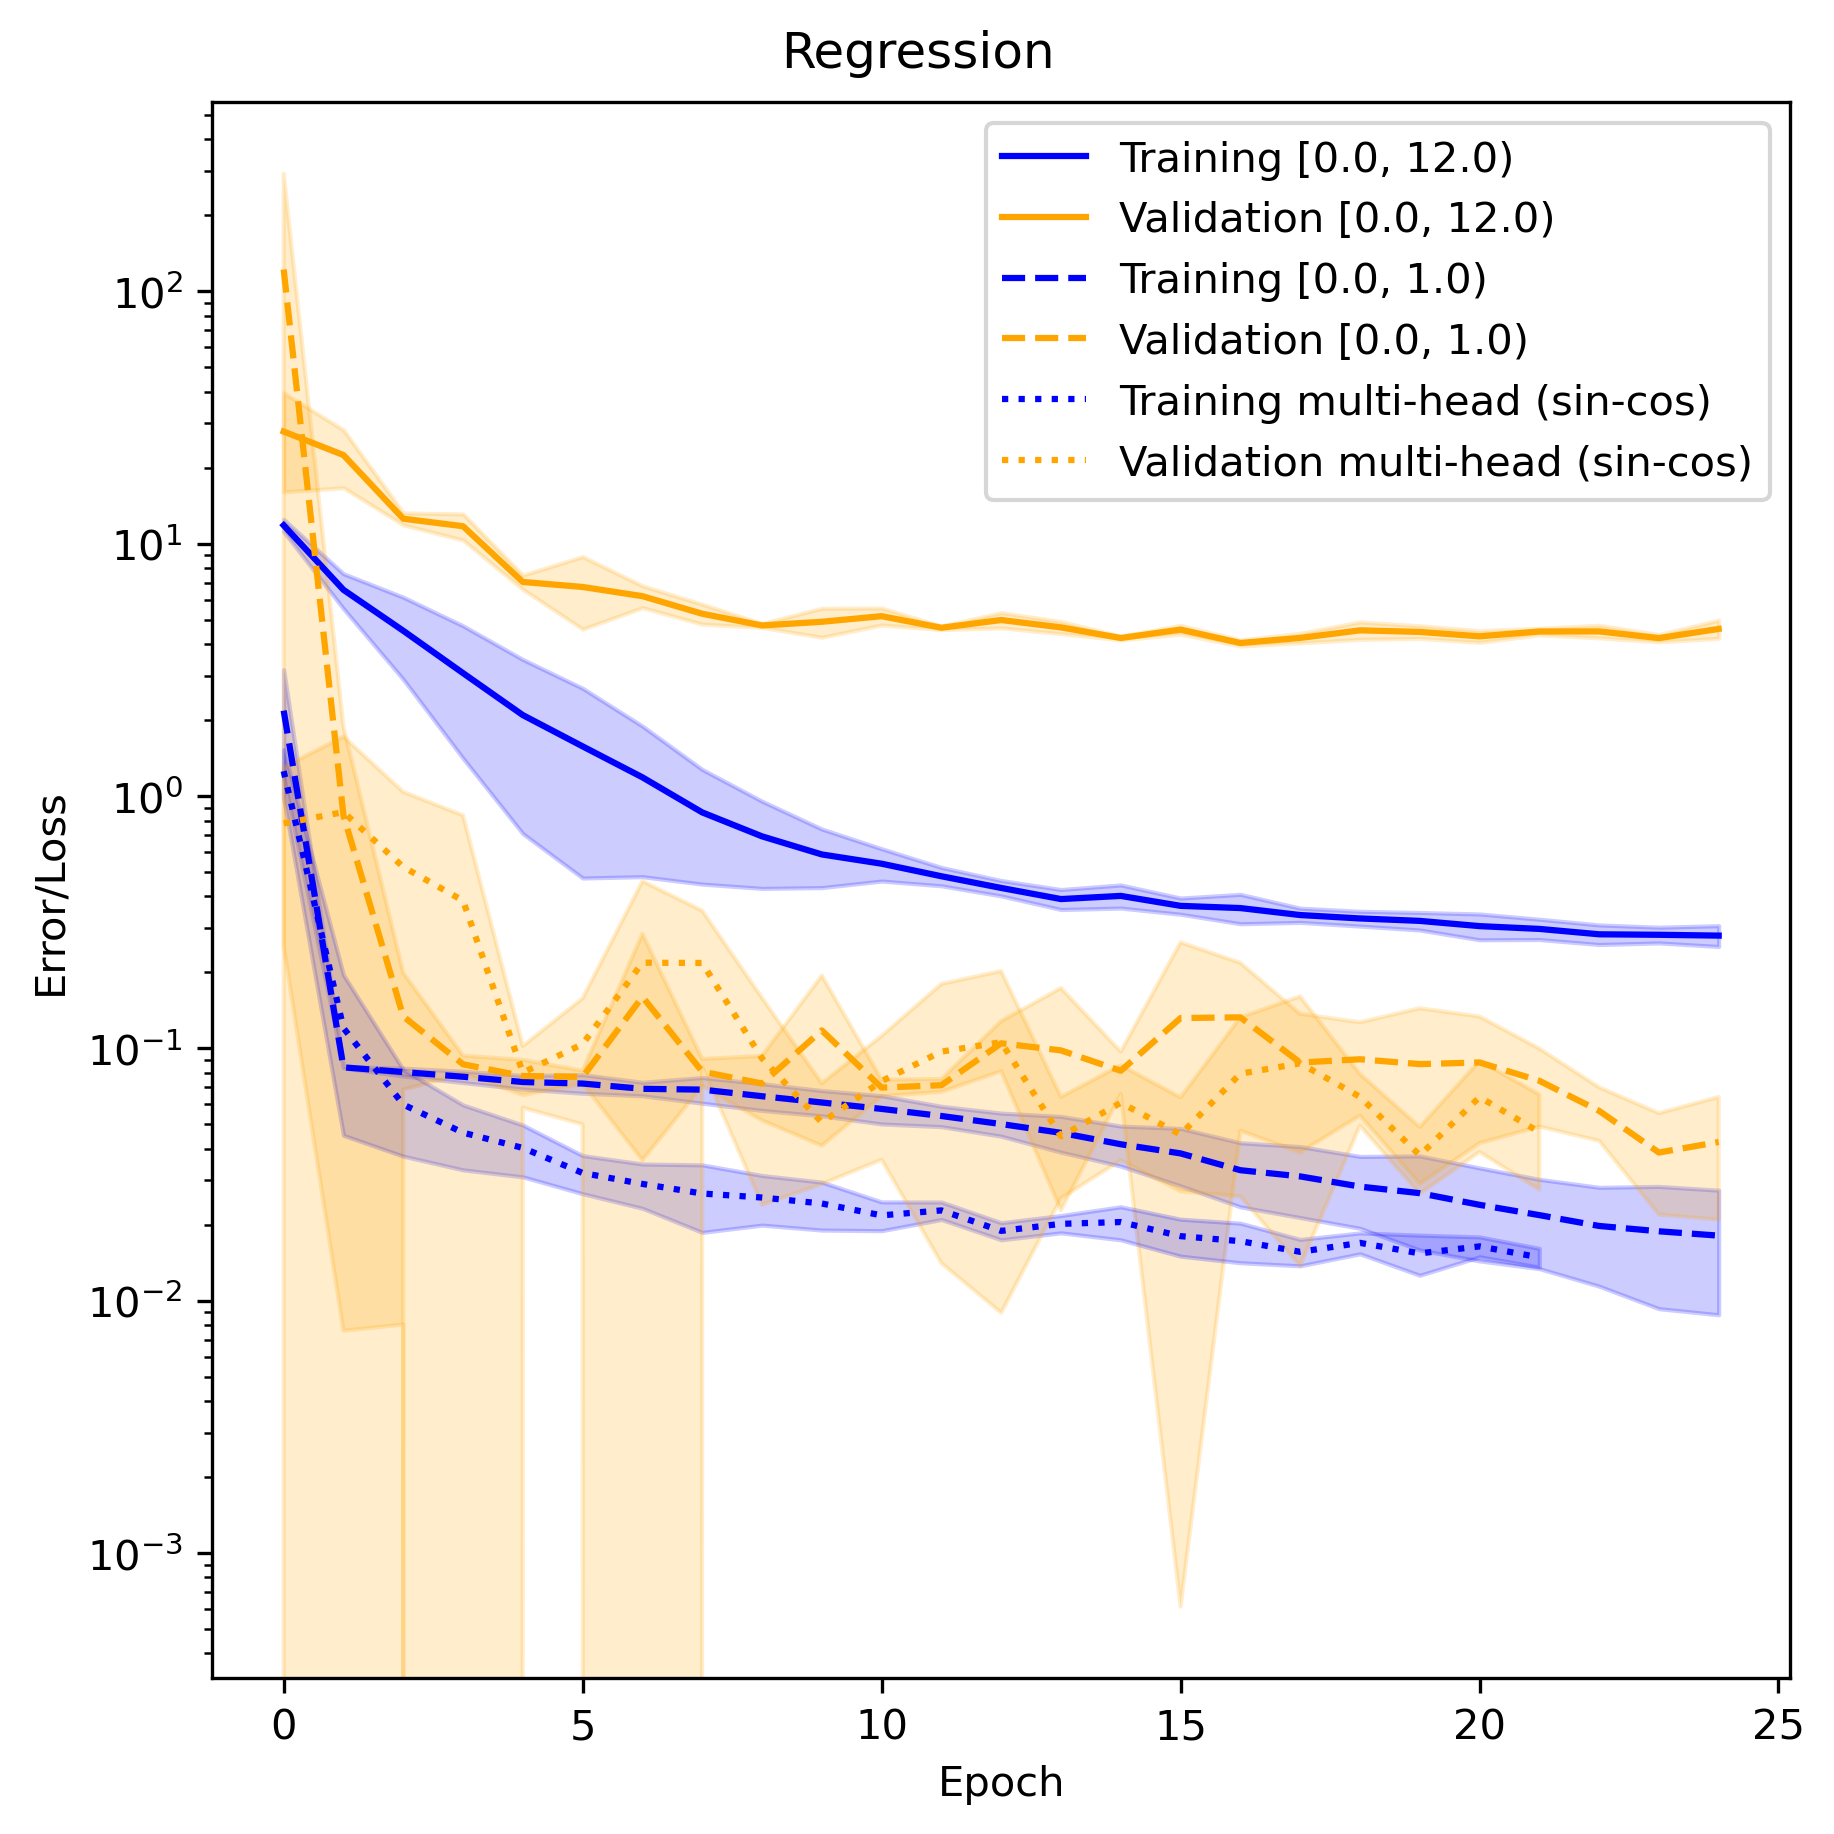

In [119]:
def plot_comb_reg_history(hists, title=""):
    fig, (ax1) = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6))
    
    colors = ["blue", "orange"]
    lss = ["solid", "dashed", "dotted"]
    labels = ["[0.0, 12.0)", "[0.0, 1.0)", "multi-head (sin-cos)"]

    # ax1.set_title(f"Loss")
    # ax2.set_title(f"Accuracy")
    for hist, ls, label in zip(hists, lss, labels):
        l = np.min([len(el["loss"]) for el in hist])
        losses = np.array([el["loss"][:l] for el in hist])
        # accuracy = np.array([el["accuracy"][:l] for el in hist])
        
        val_losses = np.array([el["val_loss"][:l] for el in hist])
        #val_accuracy = np.array([el["val_accuracy"][:l] for el in hist])
        
        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        
        mean_val_loss = np.mean(val_losses, axis=0)
        std_val_loss = np.std(val_losses, axis=0)
        
        #mean_accuracy = np.mean(losses, axis=0)
        #std_accuracy = np.std(losses, axis=0)
        
        #mean_val_accuracy = np.mean(val_losses, axis=0)
        #std_val_accuracy = np.std(val_losses, axis=0)
        
        x = np.arange(len(mean_loss))
        ax1.plot(mean_loss, label=f"Training {label}", ls=ls, c="blue")
        ax1.fill_between(x,
                        mean_loss + std_loss,
                        mean_loss - std_loss, color="blue", alpha=0.2)
        ax1.plot(mean_val_loss, label=f"Validation {label}", ls=ls, c="orange")
        ax1.fill_between(x,
                mean_val_loss + std_val_loss,
                mean_val_loss - std_val_loss, color="orange", alpha=0.2)

        
    
#         ax2.plot(mean_accuracy, label=f"Training {label}", ls=ls, c="blue")
#         ax2.fill_between(x,
#                 mean_accuracy + std_accuracy,
#                 mean_accuracy - std_accuracy, color="blue", alpha=0.2)
#         ax2.plot(mean_val_accuracy, label=f"Validation {label}", ls=ls, c="orange")
#         ax2.fill_between(x,
#                          mean_val_accuracy + std_val_accuracy,
#                          mean_val_accuracy - std_val_accuracy, color="orange", alpha=0.2)
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Error/Loss")
    ax1.legend()
    ax1.set_yscale("log")

#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Accuracy")
#     ax2.legend()
    
    fig.suptitle(title)
    
    plt.show()

    
plot_comb_reg_history([r_dec_large_result, r_dec_result, r_cossin_2head_result], "Regression")